In [76]:
import os
import math
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 8

In [78]:
def load_dataset(filename=TRAINFILE,response=response):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    #input_dataset = load_data(input_file)
    input_dataset = pd.read_csv(input_file, parse_dates=True)
    input_dataset.rename(columns={'count':'total'}, inplace=True)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    response_column =  [col for col in input_dataset.columns if response in col]
    feature_columns =  [col for col in input_dataset.columns if response not in col]
    
    print(response_column)
    print(feature_columns)
    print(input_dataset.info())
    return continuous_vars ,categorical_vars,response_column,feature_columns,input_dataset

In [79]:
def transform_dataset(continuous_vars ,categorical_vars,input_dataset):
    output_dataset = input_dataset
    season_dummies = pd.get_dummies(input_dataset['season'], prefix='season')
    # print 5 random rows
    season_dummies.sample(n=5, random_state=1)
    # drop the first column
    season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)
    # print 5 random rows
    season_dummies.sample(n=5, random_state=1)
    output_dataset = pd.concat([output_dataset, season_dummies], axis=1)
    output_dataset["hour"] = [t.hour for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset["day"] = [t.dayofweek for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset["month"] = [t.month for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset['year'] = [t.year for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset['year'] = output_dataset['year'].map({2011:0, 2012:1})
    hour_dummies = pd.get_dummies(output_dataset['hour'], prefix='hour')
    hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
    output_dataset = pd.concat([output_dataset, hour_dummies], axis=1)
    output_dataset['daytime'] = ((output_dataset['hour'] > 6) & (output_dataset['hour'] < 21)).astype(int)
    # print 5 random rows
    output_dataset.sample(n=5, random_state=1)
    output_dataset.drop('atemp',axis =1)
    
    return output_dataset

In [80]:
def plot_dataset(X,y,feature_columns,response_column):
    fig = plt.figure(figsize=(16,16))
    X_rows,X_cols = X.shape 
    for i in range(X_cols):
        if(feature_columns[i]!='datetime'):
            ax = fig.add_subplot(6, 3, i + 1)
            ax.scatter(input_dataset.iloc[:,i],y,marker=".")
            ax.set_title("{0} vs {1}".format(feature_columns[i],response_column))
            plt.tight_layout()
    plt.show()

 input file is :F:\DataSource\bike_sharing\train.csv loaded.
Continous Variables
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'total'],
      dtype='object')
Categorical Variables
Index(['datetime'], dtype='object')
['total']
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
total         10886 non-null int64
dtypes: float64(3), int64(8), ob

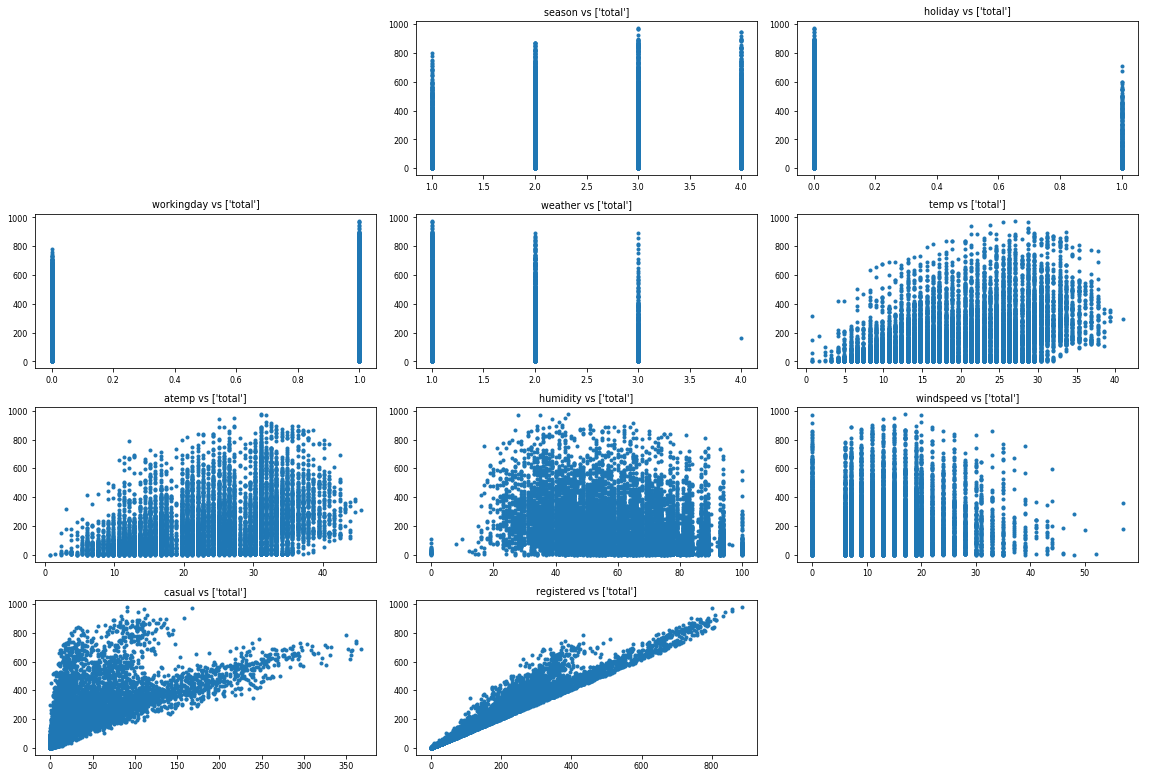

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'season_2', 'season_3', 'season_4', 'hour', 'day', 'month', 'year', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'daytime']


In [81]:
(continuous_vars ,categorical_vars,response_column,
 feature_columns,input_dataset ) = load_dataset(TRAINFILE,response)
y=input_dataset[response_column]
X=input_dataset.drop(response_column,axis=1)

plot_dataset(X,y,feature_columns,response_column)
bikes_dataset = transform_dataset(continuous_vars ,categorical_vars,input_dataset)

enhanced_feature_columns =  [col for col in bikes_dataset.columns if response not in col]

print(enhanced_feature_columns)
#pd.crosstab(bikes_dataset['season'], bikes_dataset.index.month)



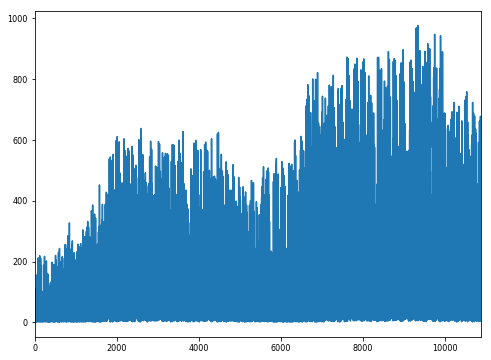

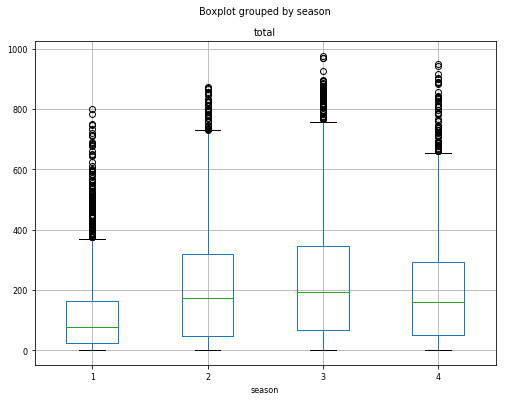

In [82]:
bikes_dataset.total.plot()
bikes_dataset.boxplot(column='total', by='season')

In [83]:
bikes_dataset.corr().sort_values('total',ascending=False)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,daytime
total,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,...,0.072405,0.144061,0.319974,0.276218,0.142797,0.042645,-0.021013,-0.066949,-0.117819,0.597553
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,...,0.031451,0.118697,0.329179,0.296144,0.153190,0.050162,-0.014882,-0.061716,-0.112840,0.571080
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,...,0.167442,0.163486,0.164982,0.106204,0.054630,0.002974,-0.031198,-0.056163,-0.086048,0.440110
daytime,-0.005797,-0.000269,0.002281,0.011727,0.164638,0.155730,-0.331914,0.209527,0.440110,0.571080,...,0.175755,0.175755,0.175755,0.175755,0.175755,0.175755,-0.248756,-0.248756,-0.248756,1.000000
hour,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,0.302045,0.380540,...,0.104566,0.134801,0.165036,0.195272,0.225507,0.255743,0.285978,0.316213,0.346449,0.337511
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,...,0.081880,0.077489,0.065038,0.050367,0.030436,0.013931,-0.000354,-0.012467,-0.023808,0.164638
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,...,0.078396,0.073191,0.060075,0.047119,0.029169,0.015231,0.001621,-0.010430,-0.021702,0.155730
hour_17,-0.001239,-0.000075,0.000513,-0.002028,0.065038,0.060075,-0.124575,0.077874,0.164982,0.329179,...,-0.043720,-0.043720,1.000000,-0.043720,-0.043720,-0.043720,-0.043720,-0.043720,-0.043720,0.175755
hour_18,-0.001239,-0.000075,0.000513,0.001590,0.050367,0.047119,-0.100366,0.063611,0.106204,0.296144,...,-0.043720,-0.043720,-0.043720,1.000000,-0.043720,-0.043720,-0.043720,-0.043720,-0.043720,0.175755
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.145241,0.264265,...,-0.000807,-0.000807,-0.000807,-0.000807,-0.000807,-0.000807,-0.000807,-0.000807,-0.000807,-0.003658


In [84]:
features=['temp','season_2','season_3','season_4' ,'holiday','humidity','daytime']
y=bikes_dataset[response_column]
X=bikes_dataset[features]

print(y[0:5])
print(X.head().to_string())
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
bikes_lr =LinearRegression()
bikes_lr.fit(X,y)
# print the coefficients
print (bikes_lr.intercept_)
print (bikes_lr.coef_)


   total
0     16
1     40
2     32
3     13
4      1
   temp  season_2  season_3  season_4  holiday  humidity  daytime
0  9.84         0         0         0        0        81        0
1  9.02         0         0         0        0        80        0
2  9.02         0         0         0        0        80        0
3  9.84         0         0         0        0        75        0
4  9.84         0         0         0        0        75        0
[-1.00516791]
[[   7.24521936   32.37193129   13.16355575   68.68996633   -7.12290146
    -1.44402076  182.40793601]]


In [91]:
(continuous_vars ,categorical_vars,response_column,
 feature_columns,input_dataset ) = load_dataset(TESTFILE,response)
bikes_dataset = transform_dataset(continuous_vars ,categorical_vars,input_dataset)
features=['temp','season_2','season_3','season_4' ,'holiday','humidity','daytime']
y=bikes_dataset[response_column]
X=bikes_dataset [features]
y_pred =bikes_lr.predict(X)
out_dataset=bikes_dataset[features]
out_dataset['y_pred']= y_pred 
print(out_dataset.head(15).to_string())
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename=TESTFILE
filename_appender ="_pred_"+timestamp+"_out.csv"
out_filename =os.path.join(input_path, DIRECTORY, filename.replace(".csv",filename_appender))
print("Predictions are written to  {0}".format(out_filename))
out_dataset.to_csv(out_filename)

 input file is :F:\DataSource\bike_sharing\test.csv loaded.
Continous Variables
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed'],
      dtype='object')
Categorical Variables
Index(['datetime'], dtype='object')
[]
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB
None
     temp  season_2  season_3  season_4  holiday  humidity  daytime      y_pred
0   10.66         0         0         0        0        56       

F:\Anaconda2\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
